<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/clicktag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Wed May  5 22:51:04 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 148 (delta 45), reused 112 (delta 20), pack-reused 0
Receiving objects: 100% (148/148), 58.56 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 77kB/s 
     |████████████████████████████████| 133kB 53.7MB/s 
     |████████████████████████████████| 13.2MB 352kB/s 
     |████████████████████████████████| 10.3MB 27.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 112kB 46.0MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 1.2MB 34.6MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/clicktag/*/*.tar.gz |xargs -n1 tar -xvf
!gunzip umi_count/*

umi_count/
umi_count/features.tsv.gz
umi_count/matrix.mtx.gz
umi_count/barcodes.tsv.gz
counts_filtered/
counts_filtered/cells_x_features.genes.txt
counts_filtered/adata.h5ad
counts_filtered/cells_x_features.barcodes.txt
counts_filtered/cells_x_features.mtx
counts_unfiltered/
counts_unfiltered/cells_x_features.genes.txt
counts_unfiltered/adata.h5ad
counts_unfiltered/cells_x_features.barcodes.txt
counts_unfiltered/cells_x_features.mtx


In [5]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

def nd(arr):
  return np.asarray(arr).reshape(-1)

colors = {
    "kb": "black",
    "cs": "red"
}

In [6]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [7]:
# citeseq outputs genes by cells, we output cells by genes
mtx_path = "/content/umi_count/matrix.mtx"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)
!yes | gzip matrix_T.mtx

In [8]:
raw_cs = import_matrix_as_anndata("./matrix_T.mtx.gz", "/content/umi_count/barcodes.tsv", "./umi_count/features.tsv", t2g_path="/content/BMGP_2020/references/clicktag/kite/f2b.txt")
raw_cs.var.index = raw_cs.var.index.map(lambda x: x.split("-")[0])

In [9]:
filtered_bcs = pd.read_csv("counts_filtered/cells_x_features.barcodes.txt", header=None)
filtered_features = pd.read_csv("counts_filtered/cells_x_features.genes.txt", header=None)

In [10]:
common = np.intersect1d(filtered_bcs.values, raw_cs.obs.index.values)
# common = np.intersect1d(raw_kb.obs.index.values, raw_cs.obs.index.values)
common_features = np.intersect1d(filtered_features.values, raw_cs.var.index.values)

In [80]:
kb = raw_kb[raw_kb.obs.index.isin(common)][:,raw_kb.var.index.isin(common_features)]
cs = raw_cs[raw_cs.obs.index.isin(common)][:,raw_cs.var.index.isin(common_features)]

In [81]:
print(kb)
print(cs)

View of AnnData object with n_obs × n_vars = 3795 × 20
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 3795 × 20


In [82]:
print(False in (kb.obs.index.values == cs.obs.index.values))
print(False in (kb.var.index.values == cs.var.index.values))

True
False


In [83]:
kb = kb[kb.obs.sort_index().index]
cs = cs[cs.obs.sort_index().index]

kb = kb[:,kb.var.sort_index().index]
cs = cs[:,cs.var.sort_index().index]

In [84]:
print(True in (kb.obs.index.values != cs.obs.index.values))
print(True in (kb.var.index.values != cs.var.index.values))

False
False


This set of reads only corresponds to clicktags 1-8, so we keep those and drop the others

In [108]:
keep = ["ClickTag1","ClickTag2","ClickTag3","ClickTag4","ClickTag5","ClickTag6","ClickTag7","ClickTag8"]

kb = kb[:,kb.var.index.isin(keep)]
cs = cs[:,cs.var.index.isin(keep)]

## Visualizations

### Knee

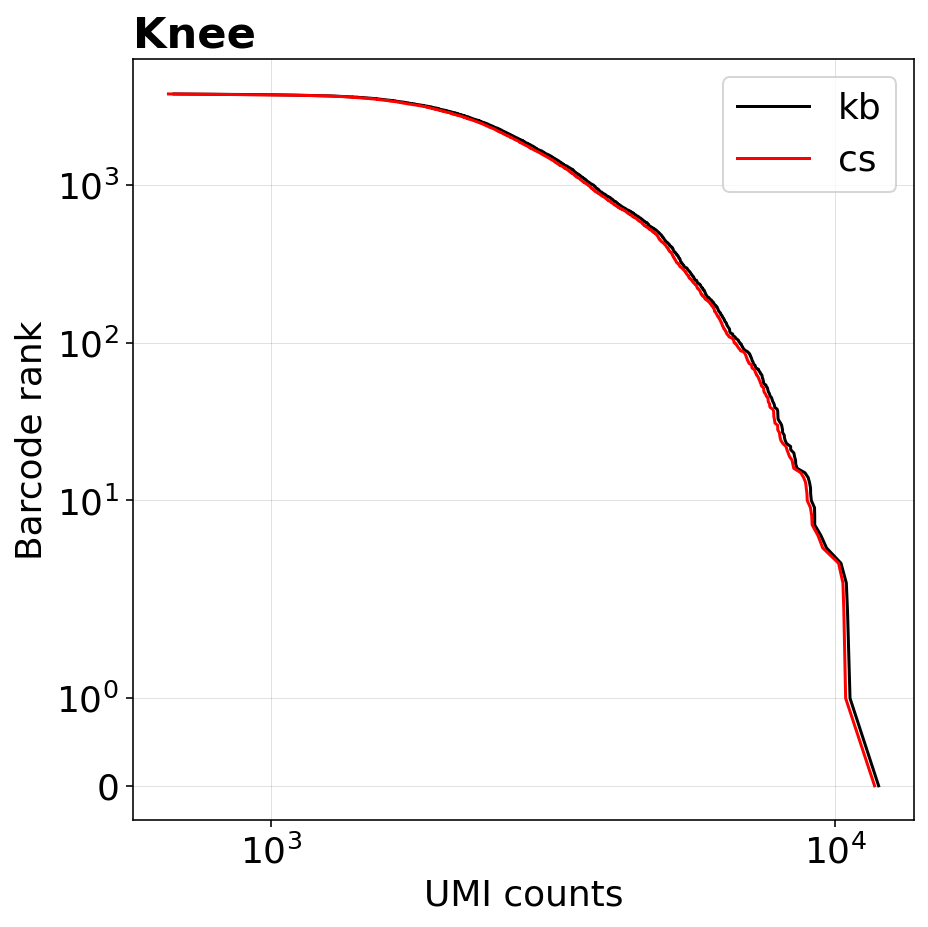

In [109]:
fig, ax = plt.subplots(figsize=(7,7))

x = np.sort(nd(kb.X.sum(axis=1)))[::-1]
y = np.arange(kb.shape[0])

ax.plot(x,y, label="kb", color=colors["kb"])

x = np.sort(nd(cs.X.sum(axis=1)))[::-1]
y = np.arange(cs.shape[0])

ax.plot(x,y, label="cs", color=colors["cs"])

ax.set(**{
    "xlabel": "UMI counts",
    "ylabel": "Barcode rank",
    "xscale": "symlog",
    "yscale": "symlog",
})
ax.legend()
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Knee', fontweight='bold', loc = 'left' )
fig.show()

In [110]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

### pseudobulk

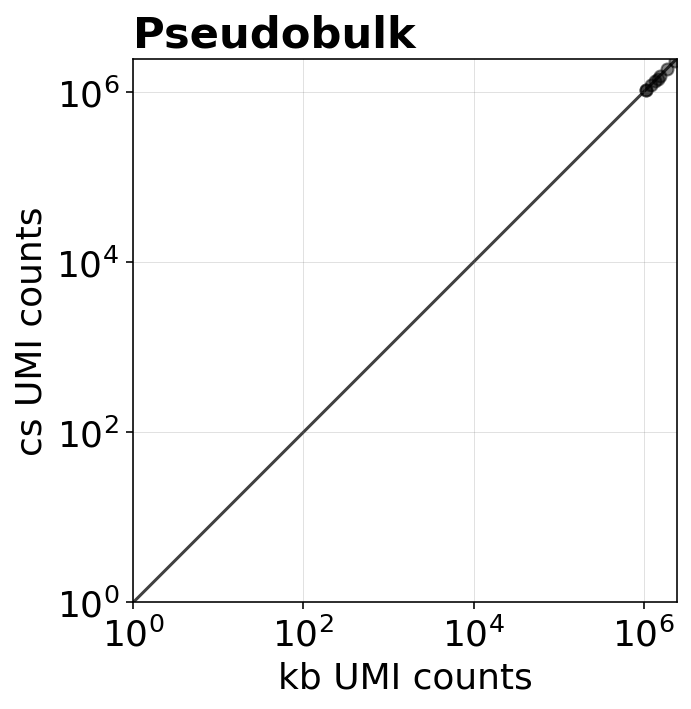

In [111]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(kb.X.sum(axis=0))
y = nd(cs.X.sum(axis=0))
ax.scatter(x,y, alpha = 0.5, color="k")

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlabel': 'kb UMI counts',
    'ylabel': 'cs UMI counts',
    'xlim': (1)
})
yex(ax)

ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Pseudobulk', fontweight='bold', loc = 'left' )
fig.show()

In [112]:
print(f"{kb.X.sum():,.0f}")
print(f"{cs.X.sum():,.0f}")

11,959,128
11,727,609


In [113]:
# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [114]:
corr = sparse_M_corr(kb.X.T, cs.X.T)
gene_corr = sparse_M_corr(kb.X, cs.X)

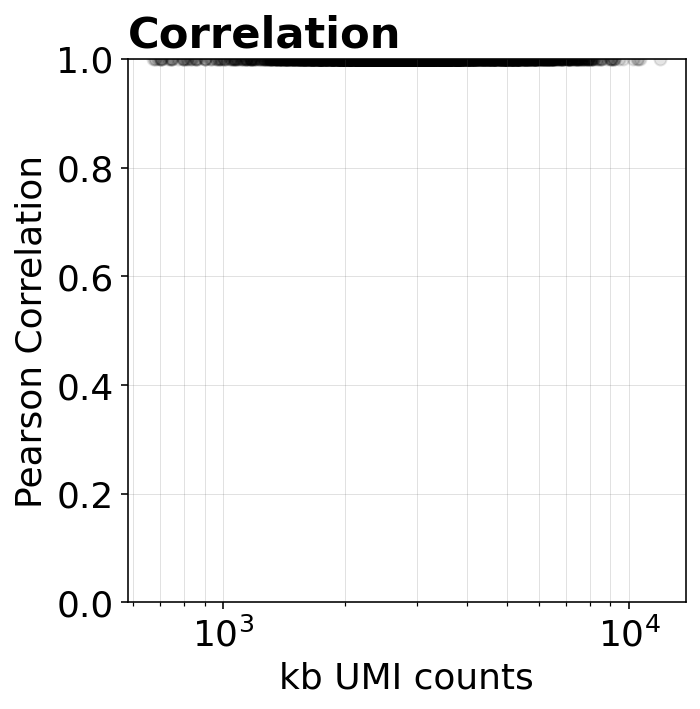

In [115]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(kb.X.sum(axis=1))
y = corr
ax.scatter(x,y, alpha=0.1, color="k")

ax.set(**{
    'xscale': 'log',
    'ylim': (0,1),
    'xlabel': 'kb UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Correlation', fontweight='bold', loc = 'left' )

fig.show()

In [116]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


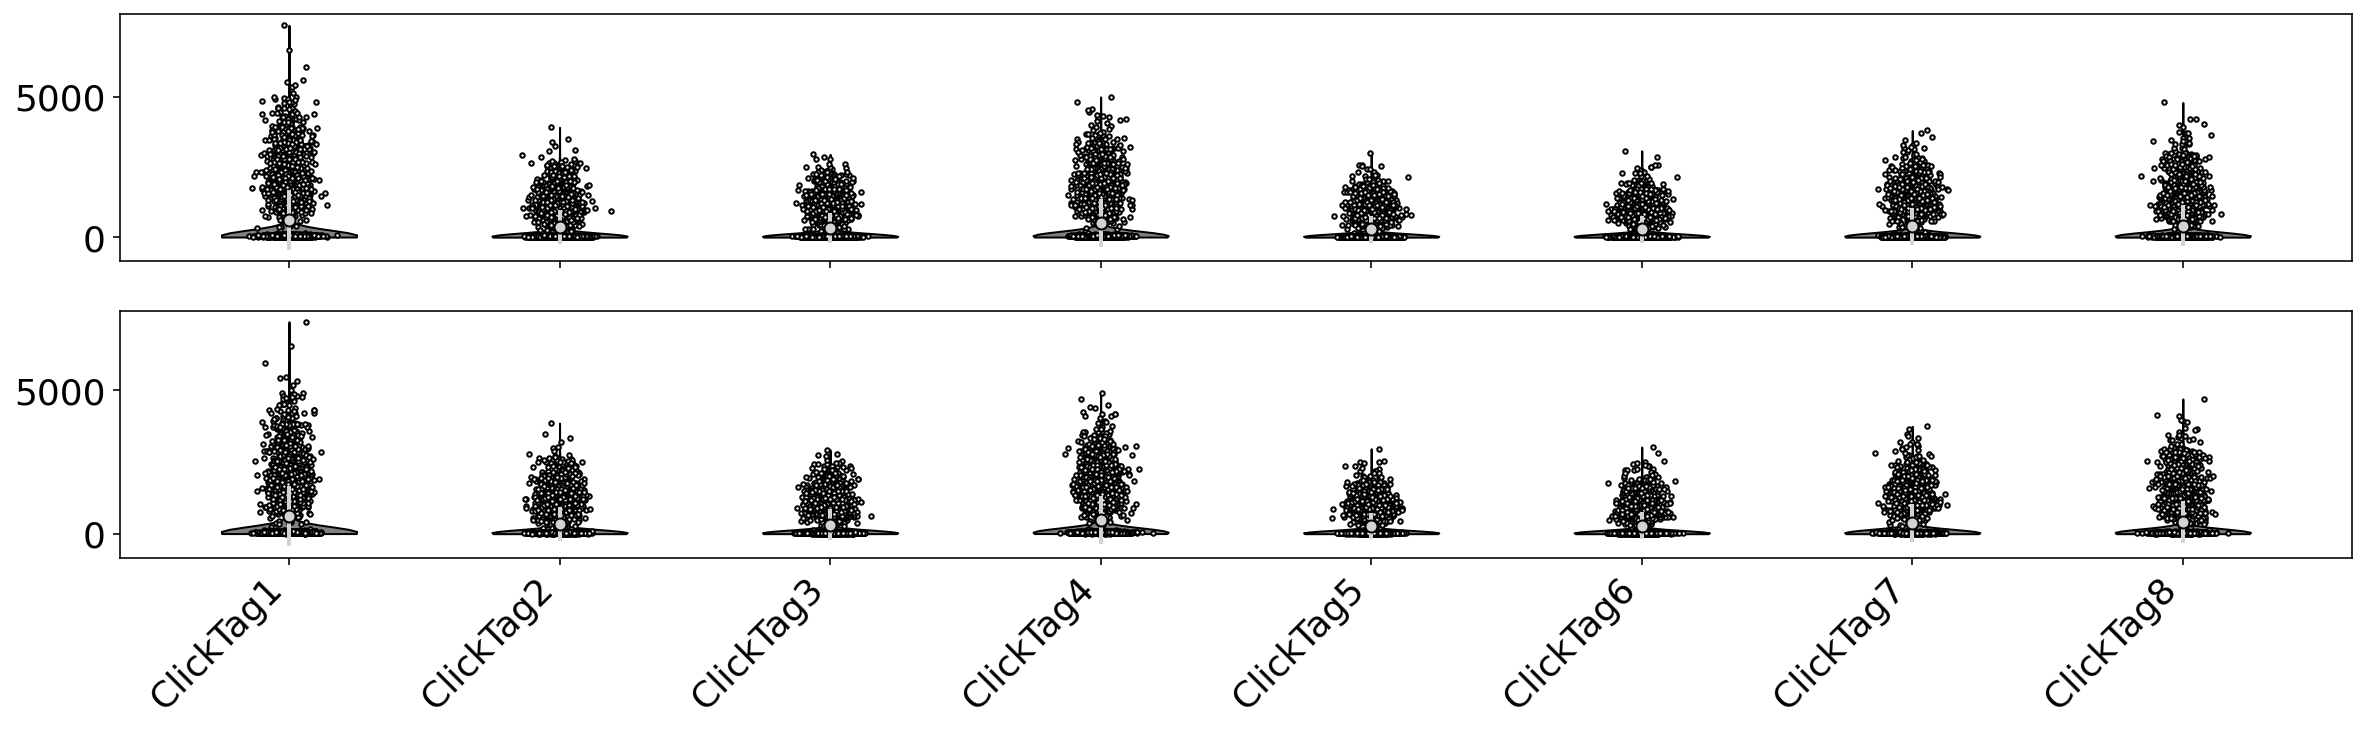

In [117]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=2)

data = kb.X.T.todense().tolist()
violinplot(data, ax[0])
ax[0].set_xticklabels([])

data = cs.X.T.todense().tolist()
violinplot(data, ax[1], xticklabels = cs.var.index.values)

ax[1].set_xticklabels(cs.var.index.values, rotation = 45, ha="right")

fig.show()

In [118]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max
    best_bins = concat_bins
    ax.hist(A, bins=concat_bins, orientation=orientation, color=colors["kb"], label="kb", alpha=1,)# bins=best_bins)
    ax.hist(B, bins=concat_bins, orientation=orientation, color=colors["cs"], label="cs", alpha=1,)# bins=best_bins)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kb", color=colors["kb"])
    ax.scatter(xx, yy, label="cs", color=colors["cs"])
#    ax.set(**{'yscale': 'log', 'xscale':'log'})
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kb", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest cr", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

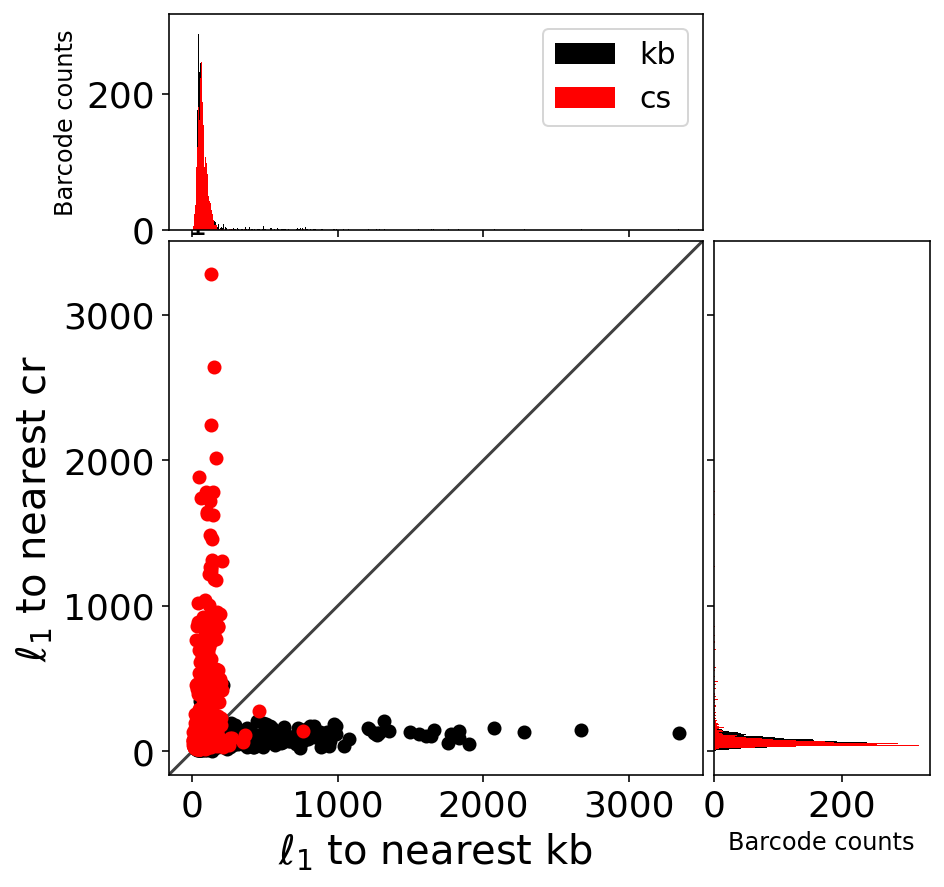

In [119]:
fig, ax = plt.subplots(figsize=(7,7))

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)
ax.set_title('$\ell_1$ distance', fontweight='bold', loc = 'left' ) # needs to be shifted up

fig.show()

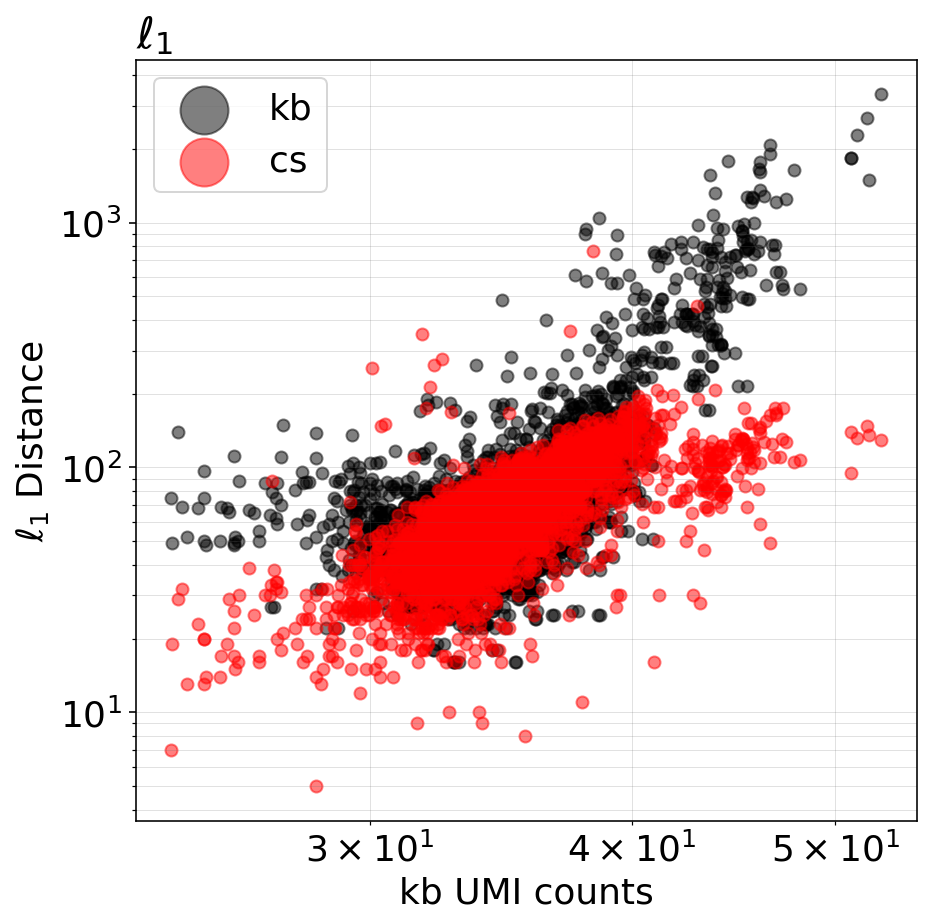

In [120]:
fig, ax = plt.subplots(figsize=(7,7))

title = "$\ell_1$"

cnts = nd(np.log1p(kb.X).sum(1))

ax.scatter(cnts, dist_AA, color=colors["kb"], alpha=0.5, label="kb")
ax.scatter(cnts, dist_AB, color=colors["cs"], alpha=0.5, label="cs")

ax.set(**{
    "xlabel": "kb UMI counts",
    "ylabel": "$\ell_1$ Distance",
    'xscale': 'log',
    'yscale': 'log',
})

ax.legend(markerscale=4, loc='upper left')
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)


ax.set_title(title, fontweight='bold', loc = 'left' )
fig.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from kb_python.utils import import_matrix_as_anndata
from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from matplotlib_venn import venn3
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})

%config InlineBackend.figure_format = 'retina'

In [28]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return ax
    ax.scatter(x,y, color="black")
    return ax

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c="black", s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar=0
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

# Load kite data

In [29]:
samples = 96
random_state = 42

In [30]:
raw = anndata.read_h5ad("/home/sina/projects/kite/clicktag/kite_out/counts_unfiltered/adata.h5ad")
raw.obs["counts"] = raw.X.sum(1)
raw.obs["num_nonzero"] = (raw.X>0).sum(1)
raw = raw[raw.obs["counts"]>0]

mtx = raw.X.todense()
raw.layers["norm"] = (mtx/raw.obs["counts"].values[:,None])*1000

OSError: ignored

In [ ]:
kite = raw[raw.obs["counts"].nlargest(50000).index.values]
print(kite)

### Perform kmeans, PCA, TSNE, UMAP on kite

In [ ]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time
kmeans.fit(kite.layers["norm"])
YY_pca = pca.fit_transform(kite.layers["norm"])
YY_tsne = tsne.fit_transform(kite.layers["norm"])
YY_umap = umap.fit_transform(kite.layers["norm"])

In [ ]:
kite.obs["kmeans"] = kmeans.labels_

kite.obs["PCA0"] = YY_pca[:,0]
kite.obs["PCA1"] = YY_pca[:,1]

kite.obs["TSNE0"] = YY_tsne[:,0]
kite.obs["TSNE1"] = YY_tsne[:,1]

kite.obs["UMAP0"] = YY_umap[:,0]
kite.obs["UMAP1"] = YY_umap[:,1]


Save assignments

In [ ]:
#adata.write_h5ad("./save/kite_adata.h5ad")

# Load cite-seq data v1.4.3

In [ ]:
path = "/home/sina/projects/kite/clicktag/cite_seq_out_no_UMI_correction/umi_count/"
mtx = path + "matrix.mtx.gz"
mtx = mmread(mtx)
mmwrite(path + "matrix_T.mtx", mtx.T)

In [ ]:
!gzip /home/sina/projects/kite/clicktag/cite_seq_out_no_UMI_correction/umi_count/matrix_T.mtx

In [ ]:
gen = path + "features.tsv.gz"
bcs = path + "barcodes.tsv.gz"
mtx = path + "matrix_T.mtx.gz"

raw_cite = import_matrix_as_anndata(mtx, bcs, gen)
raw_cite = raw_cite[raw_cite.obs.sort_index().index.values]

In [ ]:
raw_cite.var

In [ ]:
raw_cite = raw_cite[:,0:20]

In [ ]:
raw_cite.obs["counts"] = raw_cite.X.sum(1)

In [ ]:
dense = raw_cite.X.todense()
mtx = dense/dense.sum(1)*1000
raw_cite.layers["norm"] = mtx

In [ ]:
cite = raw_cite[raw_cite.obs["counts"].nlargest(50000).index.values]
print(cite)

## Perform kmeans, PCA, TSNE, UMAP on cite-seq

In [ ]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time

kmeans.fit(cite.layers["norm"])
YY_pca = pca.fit_transform(cite.layers["norm"])
YY_tsne = tsne.fit_transform(cite.layers["norm"])
YY_umap = umap.fit_transform(cite.layers["norm"])

In [ ]:
cite.obs["kmeans"] = kmeans.labels_

cite.obs["PCA0"] = YY_pca[:,0]
cite.obs["PCA1"] = YY_pca[:,1]

cite.obs["TSNE0"] = YY_tsne[:,0]
cite.obs["TSNE1"] = YY_tsne[:,1]

cite.obs["UMAP0"] = YY_umap[:,0]
cite.obs["UMAP1"] = YY_umap[:,1]


In [ ]:
#new_hto.write_h5ad("./save/new_hto_adata.h5ad")

# Jaccard similarities between technologies

In [ ]:
import itertools

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [ ]:
jaccard_1 = np.zeros((samples + 1, samples + 1))
jaccard_2 = np.zeros((samples + 1, samples + 1))
jaccard_3 = np.zeros((samples + 1, samples + 1))

In [ ]:
kite_clusters = np.sort(kite.obs.kmeans.unique())
cite_clusters = np.sort(cite.obs.kmeans.unique())
#cr_clusters = np.sort(cr.obs.kmeans.unique())

In [ ]:
#product('ABCD', repeat=2)
len(list(itertools.product(kite_clusters, repeat=2)))

In [ ]:

for i, j in list(itertools.product(kite_clusters, repeat=2)):
    a = kite[kite.obs.kmeans == i].obs.index.values
    b = cite[cite.obs.kmeans == j].obs.index.values
    #c = cr[cr.obs.kmeans == j].obs.index.values

    #d = cr[cr.obs.kmeans == i].obs.index.values
    
    jaccard_1[i, j] = jaccard_similarity(a, b) # kite vs cite
    #jaccard_2[i, j] = jaccard_similarity(a, c) # kite vs cr
    #jaccard_3[i, j] = jaccard_similarity(d, b) # cr vs cite

# Data Visualizations

In [ ]:
all_bcs = [kite.obs.index.values, cite.obs.index.values]#, cr.obs.index.values]

common_bcs = np.sort(np.array(list(set.intersection(*map(set,all_bcs)))))

In [ ]:
cmp_kite = kite[kite.obs.index.isin(common_bcs)].obs.index.values
cmp_cite = cite[cite.obs.index.isin(common_bcs)].obs.index.values
#cmp_cr = cr[cr.obs.index.isin(common_bcs)].obs.index.values

## Compare kmeans clustering on the common barcodes

1.0 is perfect

In [ ]:
print("kite vs cite: ", adjusted_rand_score(cmp_kite, cmp_cite))
#print("kite vs cr: ", adjusted_rand_score(cmp_kite, cmp_cr))
#print("cr  vs cite: ", adjusted_rand_score(cmp_cr, cmp_cite))

## Look at knee plot

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax = knee_plot(kite.obs["counts"], ax, label="kite")
knee_plot_settings(kite.obs["counts"], ax)

ax = knee_plot(cite.obs["counts"], ax, label="cite-seq")
knee_plot_settings(cite.obs["counts"], ax)


plt.legend()

plt.show()

## How well do the barcodes overlap

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

set1 = set(kite.obs.index.values) # kite
set2 = set(cite.obs.index.values)
set3 = set(cr.obs.index.values)

venn3([set1, set2, set3], ('kite', 'cite', 'cr'), alpha=0.8)
plt.show()

## PCA on normalized counts

In [ ]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)


plot_embedding(kite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="PCA")
plot_embedding(cite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="PCA")
#plot_embedding(cr.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="PCA")

plt.show()

## UMAP on normalized counts

In [ ]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="UMAP")
plot_embedding(cite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="UMAP")
#plot_embedding(cr.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="UMAP")

plt.show()

## tSNE on normalized counts

In [ ]:
# plot the number of counts
# make colors discrete

In [ ]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="TSNE")
plot_embedding(cite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="TSNE")
# plot_embedding(cr.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="TSNE")

plt.show()

## Each dot is a cell, sum counts and compare

In [ ]:
kite_bulk = kite[kite.obs.index.isin(common_bcs)].obs.counts
cite_bulk = cite[cite.obs.index.isin(common_bcs)].obs.counts
#cr_bulk = cr[cr.obs.index.isin(common_bcs)].obs.counts

In [ ]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

plot_bulk(kite_bulk, cite_bulk, xlabel="kite umi counts", ylabel="cite-seq umi counts", ax=ax)
#plot_bulk(kite_bulk, cr_bulk, xlabel="kite umi counts", ylabel="cell ranger umi counts", ax=ax[1])
#plot_bulk(cr_bulk, cite_bulk, xlabel="cell ranger umi counts", ylabel="cite-seq umi counts", ax=ax[2])

plt.show()

In [ ]:
print("r-squared values\n--")
slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cite_bulk)
print("kite & cite-seq:\t", r_value**2)

# slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cr_bulk)
# print("kite & cell ranger:\t", r_value**2)
# 
# slope, intercept, r_value, p_value, std_err = stats.linregress(cr_bulk, cite_bulk)
# print("cell ranger & cite:\t", r_value**2)

## Pearson correlation on barcodes

In [ ]:
corr_1 = sparse_M_corr(kite[common_bcs].X.T, cite[common_bcs].X.T)
# corr_2 = sparse_M_corr(kite[common_bcs].X.T, cr[common_bcs].X.T)
# corr_3 = sparse_M_corr(cr[common_bcs].X.T, cite[common_bcs].X.T)

In [ ]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

corr_plot(kite[common_bcs].obs["counts"].values, corr_1, ax=ax, xlabel="kite UMI counts", leg=["kite", "kite-seq"])
# corr_plot(kite[common_bcs].obs["counts"].values, corr_2, ax=ax[1], xlabel="kite UMI counts", leg=["kite", "cell ranger"])
# corr_plot(cr[common_bcs].obs["counts"].values, corr_3, ax=ax[2], xlabel="cell ranger UMI counts", leg=["cell ranger", "cite-seq"])
# 
plt.legend()
plt.show()

# Clustering Analysis

In [ ]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
heatmap(jaccard_1, kite_clusters, cite_clusters, ax=ax[0], cmap="cividis")
heatmap(jaccard_2, kite_clusters, cite_clusters, ax=ax[1], cmap="cividis")
heatmap(jaccard_3, kite_clusters, cite_clusters, ax=ax[2], cmap="cividis")
plt.show()

## Per cluster correlations

In [ ]:
cluster_corr = []
cluster_size = []
for idx, cluster in enumerate(np.argmax(jaccard_1, axis=0)):
    a = kite[kite.obs.kmeans == idx]
    b = cite[cite.obs.kmeans == cluster]
    
    bcs = [a.obs.index.values, b.obs.index.values]
    
    common = np.sort(np.array(list(set.intersection(*map(set,bcs)))))
    
    cluster_corr.append(sparse_M_corr(a[common].X.T, b[common].X.T))
    
    cluster_size.append(common.shape[0])

In [ ]:
variance = [i.var() for i in cluster_corr]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.boxplot(cluster_corr, sym='black')
ax.set_ylim(0,1)
ax.set_ylabel("Correlation coefficient")
ax.set_xlabel("Cluster number")
ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.2)


new_tick_locations = np.arange(1, samples+2)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(cluster_size)
ax2.set_xticklabels(['{:,}'.format(int(x)) for x in cluster_size])
ax2.xaxis.set_tick_params(rotation=45)



ax2.set_xlabel("Cluster size")

ax3 = ax.twinx()
ax3.plot(new_tick_locations, variance, color="red", linewidth=5)
ax3.set_ylim(0, 1)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax3.set_ylabel("Variance")

black_dot = mpatches.Patch(color='black', label='Correlation')
red_line = mpatches.Patch(color='red', label='Variance')
plt.legend(handles=[black_dot, red_line], loc="lower right")

plt.show()